
# Ingest New Atmospheric Models into SEDA

Tutorial to show how users can use models not in the [list of available models](https://seda.readthedocs.io/en/latest/overview.html#available-atmospheric-models).

In [1]:
import seda
import pickle
import numpy as np
import os
import json
import importlib
import fnmatch


    SEDA v0.1.2 package imported


Available models:

In [2]:
seda.Models().available_models

['BT-Settl',
 'ATMO2020',
 'Sonora_Elf_Owl',
 'Exo-REM',
 'SM08',
 'Sonora_Bobcat',
 'Sonora_Diamondback',
 'Sonora_Cholla',
 'LB23']

If the models you are interested in are not listed above, you can ingest new models by following the steps in the tutorial.

As an example, let's ingest the Exo-REM models, which are not available as of May 27, 2025.

First, let's create a JSON file containing basic information for the models to be used throughout the code and accessed via several attributes of seda.Models(). To do this, make a dictionary with relevant parameters by following the script below, modifing only the lines marked with the comment "fill out accordingly". Then save the dictionary in `models_aux/model_specifics` using the naming convention "`model`_models.json" (the script below should automatically find the appropriate path and name to save the file, so just double check the new json file was stored in `models_aux/model_specifics`):

In [3]:
data = {
    "_comment_model": "Internal label for the atmospheric models",
    "model": "Exo-REM", # fill out accordingly
    "_comment_ref": "Reference for the models (optional)",
    "ref": "Charnay et al. (2018)",  # fill out accordingly
    "_comment_name": "Name of the models (optional)",
    "name": "Exo-REM", # fill out accordingly
    "_comment_bibcode": "bibcode identifier for the models (optional)",
    "bibcode": "2018ApJ...854..172C", # fill out accordingly
    "_comment_ADS": "ADS links to the model publication (optional)",
    "ADS": "https://ui.adsabs.harvard.edu/abs/2018ApJ...854..172C/abstract", # fill out accordingly
    "_comment_download": "Link to download the models (optional)",
    "download": "https://lesia.obspm.fr/exorem/YGP_grids/", # fill out accordingly
    "_comment_filename_pattern": "Common pattern recognized in all spectra filenames used to select only spectra files in case there are other files in the same directory",
    "filename_pattern": "spectra_YGP_*.dat", # fill out accordingly
    "_comment_free_params": "Free parameters in the models",
    "free_params": ["Teff", "logg", "Z", "CtoO"] # fill out accordingly
}

# file path to save the JSON file
file_path = os.path.dirname(seda.__file__)+'/models_aux/model_specifics/'
# file name
file = f"{data['model']}_models.json"

# write the dictionary to a JSON file
with open(file_path+file, 'w') as json_file:
    json.dump(data, json_file, indent=4)

print(f"JSON file '{file}' created successfully.")

JSON file 'Exo-REM_models.json' created successfully.


Next, let's make a script that reads the free parameters for each spectrum from file names. The parameters obtained from file names must match the free parameters `free_params` in the dictionary made above. **Just for now**, we can edit the function `separate_params` in module `models.py` to add a conditional for the new models, following the steps for the already available models.

Now let's create a pickle file in the folder `models_aux/model_coverage` that will store the full coverage of each free parameter in the models. This file will allow to use functions like `seda.Models(model)` and `plot_model_coverage`. To do this, only update the path below to point to the new models.

In [4]:
model_dir = '/home/gsuarez/TRABAJO/MODELS/atmosphere_models/Exo-REM/cloud_R20000_updated/'


# extract some info from the dictionary above
model = data['model']
filename_pattern = data['filename_pattern']
# find path to the folder "models_aux/model_coverage" and set the file name
file_path = os.path.dirname(seda.__file__)+'/models_aux/model_coverage/'
file = f'{model}_free_parameters.pickle'
out_file = file_path+file

# extract and save the values for all the model free parameters with spectra in the indicated directory
out = seda.select_model_spectra(model=model, model_dir=model_dir, out_file=out_file, 
                                filename_pattern=filename_pattern, save_results=True)


      13403 model spectra


Explore some info from the new models. For example, the grid points from each free parameters are obtained with:

In [5]:
seda.Models(model).params_unique

{'Teff': array([ 400.,  450.,  500.,  550.,  600.,  650.,  700.,  750.,  800.,
         850.,  900.,  950., 1000., 1050., 1100., 1150., 1200., 1250.,
        1300., 1350., 1400., 1450., 1500., 1550., 1600., 1650., 1700.,
        1750., 1800., 1850., 1900., 1950., 2000.]),
 'logg': array([3. , 3.5, 4. , 4.5, 5. ]),
 'Z': array([-0.49,  0.  ,  0.5 ,  1.  ,  1.5 ,  2.  ]),
 'CtoO': array([0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55, 0.6 ,
        0.65, 0.7 , 0.75, 0.8 ])}

We can plot the coverage of two free parameters with the function by changing `xparam` and `yparam` to any free parameters in the models:

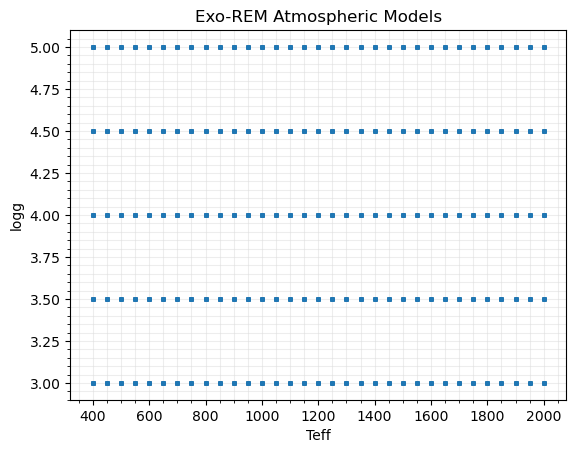

In [8]:
seda.plot_model_coverage(model=model, xparam='Teff', yparam='logg')

The last step is to indicate how to read model spectra, providing wavelengths in micron and fluxes in Jy or erg/s/cm2/A.

In [7]:
from astropy.io import ascii
from astropy import units as u
from astropy.units.equivalencies import spectral

spec_model = ascii.read(model_dir+'spectra_YGP_550K_logg5.0_met10.00_CO0.65.dat')
wl_model = spec_model['wavenumber'] # 1/cm
wl_model = (wl_model/u.cm).to(u.um, equivalencies=spectral()) # um
wl_model = wl_model.value

flux_model = spec_model['spectral_flux'] # W.m-2/cm-1 (W*cm/m2)


# HOW TO CONVERT FLUX IN W*cm/m2 to W/m2/m???
# flux_model = flux_model*u.W*u.m**-2/u.cm**-1
flux_model*u.W*u.m**-2/((u.cm**-1).to(u.m, equivalencies=spectral())*u.m)
# flux_model.to(u.erg/u.s/u.cm**2/u.angstrom)
# flux_model.to(u.W*u.m**-2/u.m**-1, equivalencies=spectral())

f'{model}_sep_params.py'

<Quantity [1.24999015, 1.11285266, 1.18589112, ..., 0.02318514, 0.02322689,
           0.02326978] W / m3>

In [10]:
d = 15*u.pc
type(d)

astropy.units.quantity.Quantity

In [ ]:
TeffXXX_loggYYY_

In [9]:
# read all the Sonora Elf Owl models
model = 'Sonora_Elf_Owl'
# all folder with model spectra
model_folders = np.array(['output_275.0_325.0/', 'output_350.0_400.0/', 
                          'output_425.0_475.0/', 'output_500.0_550.0/', 
                          'output_575.0_650.0/', 'output_700.0_800.0/', 
                          'output_850.0_950.0/', 'output_1000.0_1200.0/',
                          'output_1300.0_1400.0/', 'output_1600.0_1800.0/', 
                          'output_1900.0_2100.0/', 'output_2200.0_2400.0/'
                          ])
# path to the folder with the spectra
model_path = '/home/gsuarez/TRABAJO/MODELS/atmosphere_models/Sonora_Elf_Owl/spectra/'
# attach the path to each folder
model_dir = np.char.add(model_path, model_folders)

model = 'Sonora_Diamondback'
model_dir = ['/home/gsuarez/TRABAJO/MODELS/atmosphere_models/Sonora_Diamondback/spectra/']
model = 'LB23'
model_dir = '/home/gsuarez/TRABAJO/MODELS/atmosphere_models/LB2023_extended/LB2023_extended/Spectra/'
model = 'Sonora_Cholla'
model_dir = '/home/gsuarez/TRABAJO/MODELS/atmosphere_models/Sonora_Cholla/spectra_files/'
model = 'Sonora_Bobcat'
model_dir = ['/home/gsuarez/TRABAJO/MODELS/atmosphere_models/Sonora_Bobcat/spectra_m+0.0/',
             '/home/gsuarez/TRABAJO/MODELS/atmosphere_models/Sonora_Bobcat/spectra_m+0.5/',
             '/home/gsuarez/TRABAJO/MODELS/atmosphere_models/Sonora_Bobcat/spectra_m-0.5/',
             '/home/gsuarez/TRABAJO/MODELS/atmosphere_models/Sonora_Bobcat/spectra_m+0.0_co0.5_g1000nc/',
             '/home/gsuarez/TRABAJO/MODELS/atmosphere_models/Sonora_Bobcat/spectra_m+0.0_co1.5_g1000nc/',
            ]
model = 'ATMO2020'
model_dir = ['/home/gsuarez/TRABAJO/MODELS/atmosphere_models/ATMO2020/atmosphere_models/CEQ_spectra/',
             '/home/gsuarez/TRABAJO/MODELS/atmosphere_models/ATMO2020/atmosphere_models/NEQ_weak_spectra/',
             '/home/gsuarez/TRABAJO/MODELS/atmosphere_models/ATMO2020/atmosphere_models/NEQ_strong_spectra/',
            ]
model = 'BT-Settl'
model_dir = ['/home/gsuarez/TRABAJO/MODELS/atmosphere_models/Allard_Models/BT-Settl/CIFIST2011c/SPECTRA/']
model = 'SM08'
model_dir = '/home/gsuarez/TRABAJO/MODELS/atmosphere_models/Saumon_Marley_2008_models/spectra/'


# get all spectra files in the directories
# and save then in the folder seda/models_aux/model_coverage/
out = seda.select_model_spectra(model=model, model_dir=model_dir, save_results=True)


      226 model spectra

         Coverage of free parameter saved successfully
